In [6]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import math
import numpy as np
import scipy.sparse as sparse
%matplotlib inline

G = nx.Graph()

# Read Edges file and cleanup
lines = [line.rstrip('\n') for line in open('facebook/3437.edges')]
lines = [line.split(" ") for line in lines]
lines = [(int(line[0]), int(line[1])) for line in lines]
print(len(lines))
print(lines[0:10])

9626
[(3825, 3568), (3549, 3905), (3750, 3596), (3710, 3713), (3611, 3542), (3726, 3972), (3633, 3448), (3550, 3968), (1085, 3721), (3623, 3866)]


In [7]:
G.add_edges_from(lines)
print(G.number_of_nodes())
print(G.number_of_edges())

534
4813


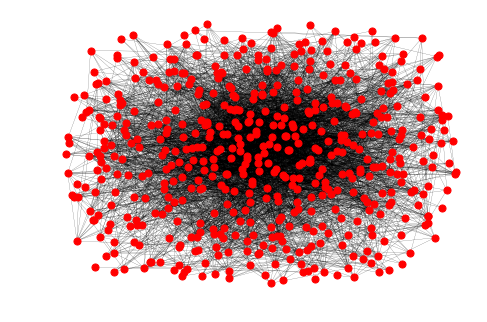

In [4]:
nx.draw(G, node_size= 50, width=.15, pos=nx.spring_layout(G, k=0.25, iterations=5))
plt.show()

Population: 534
Beta: 0.0372773963114
Initially, 6 people were infected ([3864, 3858, 3635, 3599, 3548, 3630])
Iteration 0


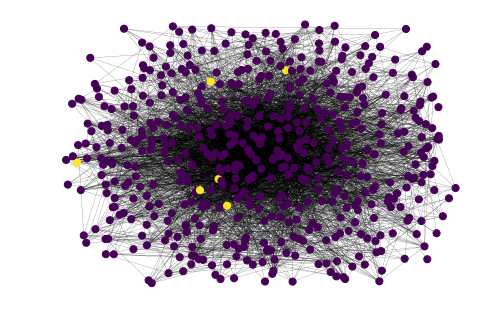

Iteration 1


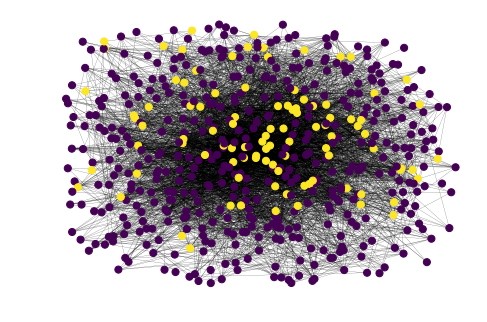

Iteration 2


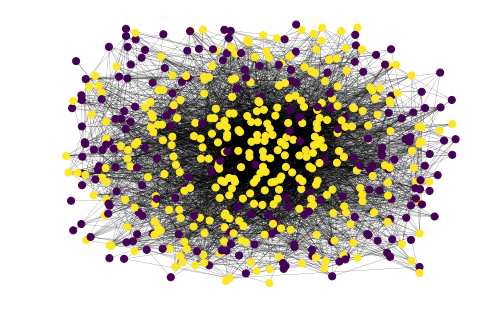

Iteration 3


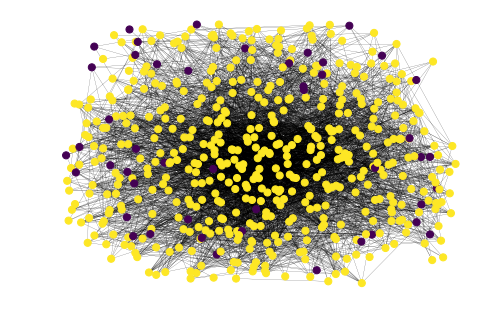

Iteration 4


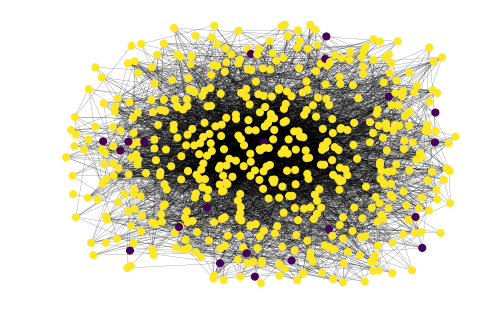

Iteration 5


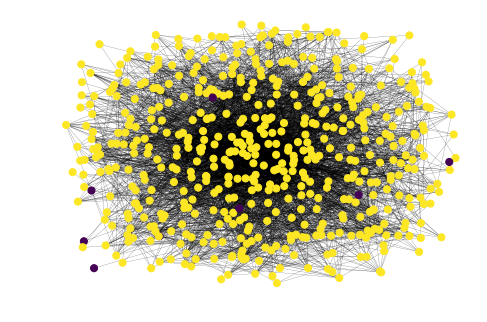

Iteration 6


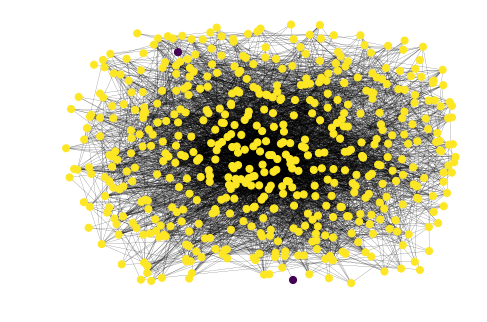

Iteration 7


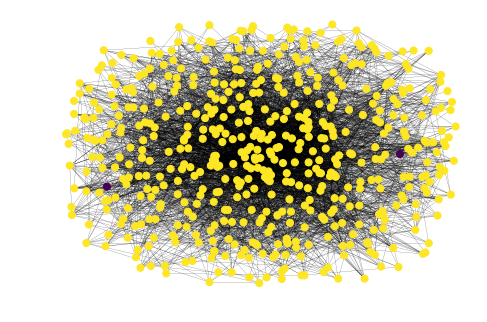

Iteration 8


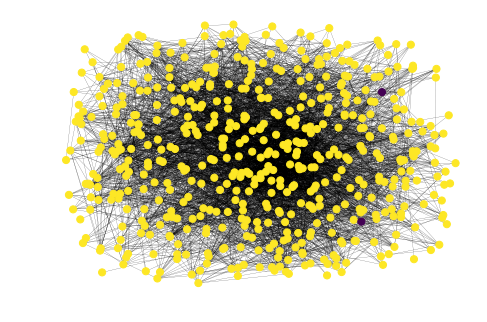

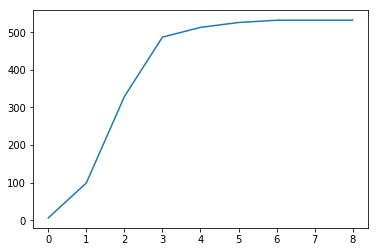

At the end, 532 people were infected


In [5]:
def si_model(graph, TIME_STEPS):
    n = graph.number_of_nodes() # Population
    b = random.uniform(0.001, 0.05) # Spread rate (while keeping things interesting)
    print("Population: " + str(n))
    print("Beta: " + str(b))
    # Pick a subset as the source of the infection
    # I have artifically set a cap of 1% of population as the source max
    # We randomly add 1 node so we always have a source
    # After this, we add up to 1% of the population randomly (some chance they get added)
    susceptible = list(graph.nodes())
    infected = []
    infected.append(susceptible.pop(random.randrange(len(susceptible))))
    for x in range(int(0.01 * n)):
        if random.uniform(0.0, 1.0) > b:
            infected.append(susceptible.pop(random.randrange(len(susceptible))))
    
    # We now simulate a number of timesteps and note how many infected we have at each step
    # This can then be plotted against the standard equation for a SI model
    x_0 = len(infected) # For plot
    print("Initially, " + str(x_0) + " people were infected (" + str(infected) + ")")
    
    infected_time = []
    infected_time.append(len(infected))
    print("Iteration 0")
    values = [0.57 if node in infected else 0.25 for node in graph.nodes()]
    nx.draw(graph, node_color=values, node_size= 50, width=.15, pos=nx.spring_layout(graph, k=0.25, iterations=5))
    plt.show()
    
    for i in range(0, TIME_STEPS):
        # Find the people who are prone to infection
        frontier = []
        for n in infected:
            l = [x for x in list(graph.neighbors(n)) if x in susceptible]
            for k in l:
                if k not in infected:
                    frontier.append(k)

        # Infect the prone people with chance b
        for p in frontier:
            if p in frontier: # Make sure we didn't already remove it
                if random.uniform(0.0, 1.0) > b: 
                    # Remove from frontier
                    frontier = [x for x in frontier if x != p]
                    # Add to infected
                    infected.append(p)
                    # Remove from suspectible
                    susceptible.remove(p)
        # Record number infected
        infected_time.append(len(infected))
        values = [0.57 if node in infected else 0.25 for node in graph.nodes()]
        print("Iteration " + str(i + 1))
        nx.draw(graph, node_color=values, node_size= 50, width=.15, pos=nx.spring_layout(graph, k=0.25, iterations=5))
        plt.show()
    
    # Graph the values
    plt.plot(infected_time)
    plt.show()
    print("At the end, " + str(len(infected)) + " people were infected")

si_model(G, 8)

Population: 534
Beta: 0.042258744474
Initially, 6 people were infected ([(3763, 3), (3736, 3), (3788, 3), (3898, 3), (3757, 3), (3535, 3)])
Iteration 0


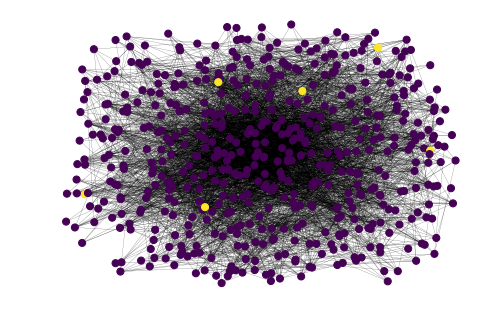

Iteration 1


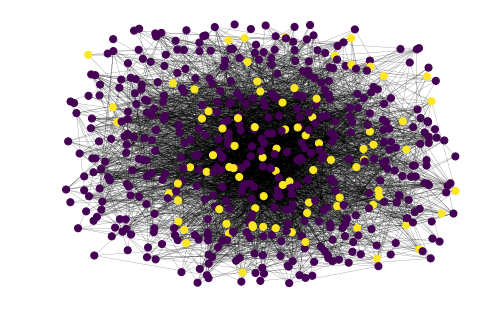

Iteration 2


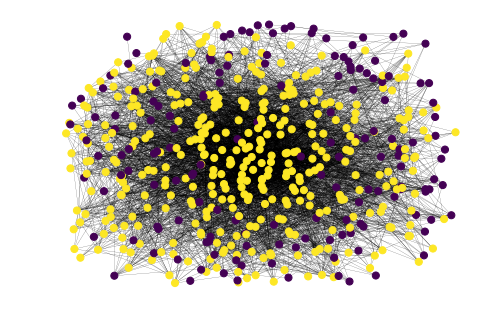

Iteration 3


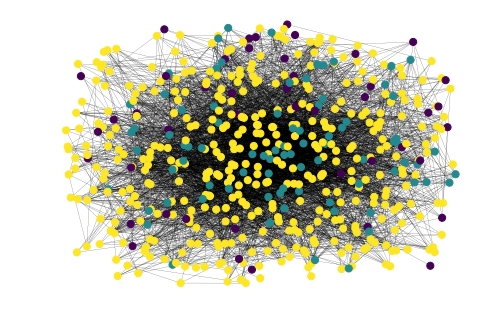

Iteration 4


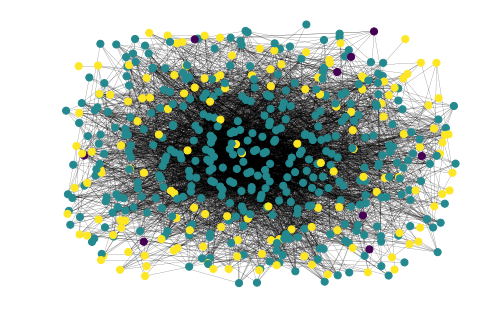

Iteration 5


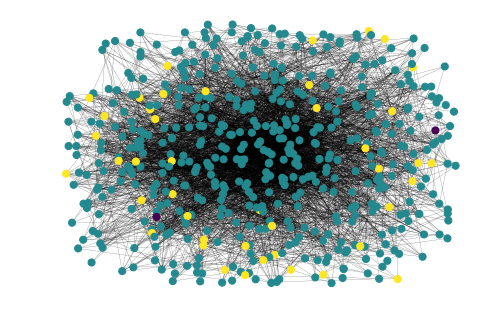

Iteration 6


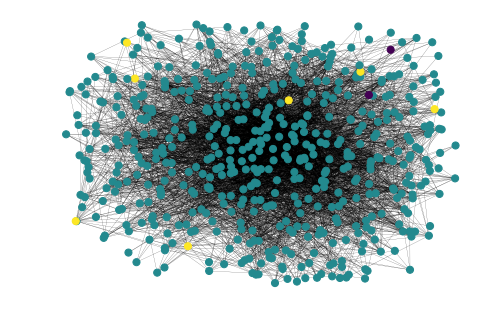

Iteration 7


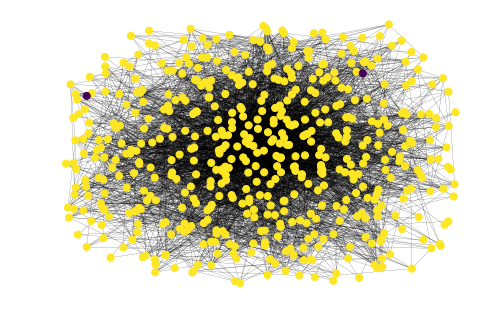

Iteration 8


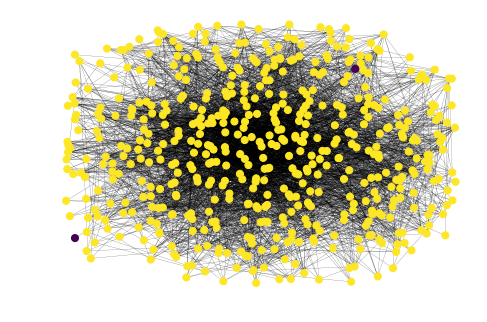

Iteration 9


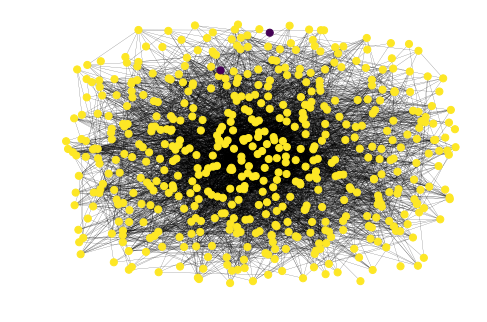

Iteration 10


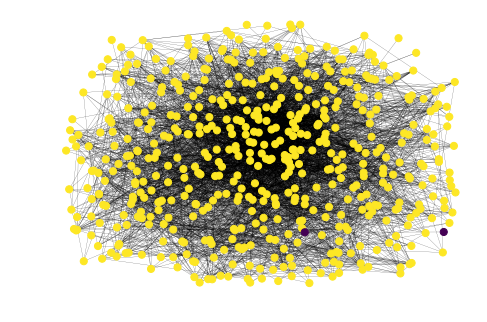

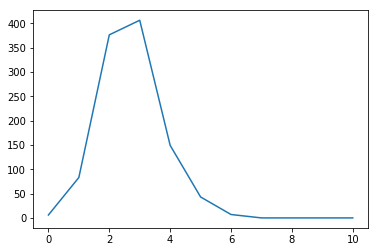

At the end, 0 people were infected


In [6]:
def sir_model(graph, TIME_STEPS):
    n = graph.number_of_nodes() # Population
    b = random.uniform(0.001, 0.05) # Spread rate (while keeping things interesting)
    r = 3
    print("Population: " + str(n))
    print("Beta: " + str(b))
    
    # Pick a subset as the source of the infection
    # I have artifically set a cap of 1% of population as the source max
    # We randomly add 1 node so we always have a source
    # After this, we add up to 1% of the population randomly (some chance they get added)
    susceptible = list(graph.nodes())
    infected = []
    recovered = []
    infected.append( (susceptible.pop(random.randrange(len(susceptible))), r) )
    for x in range(int(0.01 * n)):
        if random.uniform(0.0, 1.0) > b:
            infected.append( (susceptible.pop(random.randrange(len(susceptible))), r) )
    
    # We now simulate a number of timesteps and note how many infected we have at each step
    # This can then be plotted against the standard equation for a SI model
    x_0 = len(infected) # For plot
    print("Initially, " + str(x_0) + " people were infected (" + str(infected) + ")")
    
    infected_time = []
    infected_time.append(len(infected))
    print("Iteration 0")
    values = [0.57 if node in [x[0] for x in infected] else .4 if node in recovered else 0.25 for node in graph.nodes()]
    nx.draw(graph, node_color=values, node_size= 50, width=.15, pos=nx.spring_layout(graph, k=0.25, iterations=5))
    plt.show()
    
    for i in range(0, TIME_STEPS):
        # Find the people who are prone to infection
        frontier = []
        for n in infected:
            l = [x for x in list(graph.neighbors(n[0])) if x in susceptible]
            for k in l:
                if k not in [x[0] for x in infected]:
                    frontier.append(k)

        # Infect the prone people with chance b
        for p in frontier:
            if p in frontier: # Make sure we didn't already remove it
                if random.uniform(0.0, 1.0) > b: 
                    # Remove all instances from frontier
                    frontier = [x for x in frontier if x != p]
                    # Add to infected
                    if p not in [x[0] for x in infected]:
                        infected.append((p, r))
                    # Remove from suspectible
                    if p in susceptible:
                        susceptible.remove(p)
        
        # Cure the infected people
        for n in range(len(infected)):
                infected[n] = (infected[n][0], infected[n][1] - 1)
        
        recovered = recovered + [x[0] for x in infected if x[1] <= 0]
        infected = [x for x in infected if x[1] > 0]
        
        # Record number infected
        infected_time.append(len(infected))
        values = [0.57 if node in [x[0] for x in infected] else .4 if node in recovered else 0.25 for node in graph.nodes()]
        print("Iteration " + str(i + 1))
        nx.draw(graph, node_color=values, node_size= 50, width=.15, pos=nx.spring_layout(graph, k=0.25, iterations=5))
        plt.show()
    
    # Graph the values
    plt.plot(infected_time)
    plt.show()
    print("At the end, " + str(len(infected)) + " people were infected")

sir_model(G, 10)

Population: 534
Beta: 0.0322895483479
Initially, 5 people were infected ([3596, 3902, 3932, 3556, 3619])
Iteration 0


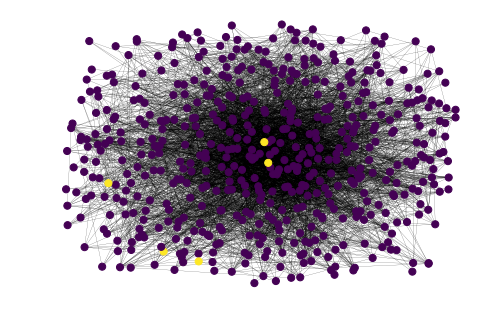

Iteration 50


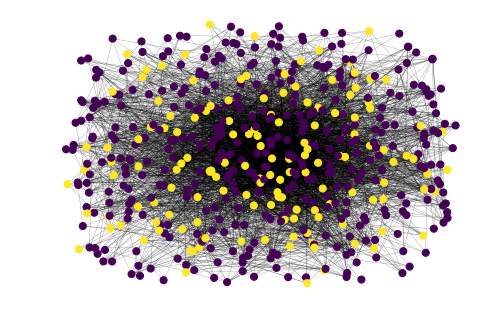

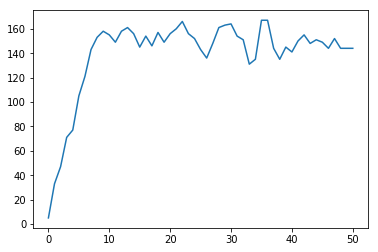

At the end, 144 people were infected


In [7]:
def sis_model(graph, TIME_STEPS):
    n = graph.number_of_nodes() # Population
    b = random.uniform(0.001, 0.05) # Spread rate (while keeping things interesting)
    r = random.uniform(0.00001, b) # Rate of healing
    print("Population: " + str(n))
    print("Beta: " + str(b))
    # Pick a subset as the source of the infection
    # I have artifically set a cap of 1% of population as the source max
    # We randomly add 1 node so we always have a source
    # After this, we add up to 1% of the population randomly (some chance they get added)
    susceptible = list(graph.nodes())
    infected = []
    infected.append(susceptible.pop(random.randrange(len(susceptible))))
    for x in range(int(0.01 * n)):
        if random.uniform(0.0, 1.0) > b:
            infected.append(susceptible.pop(random.randrange(len(susceptible))))
    
    # We now simulate a number of timesteps and note how many infected we have at each step
    # This can then be plotted against the standard equation for a SI model
    x_0 = len(infected) # For plot
    print("Initially, " + str(x_0) + " people were infected (" + str(infected) + ")")
    
    infected_time = []
    infected_time.append(len(infected))
    print("Iteration 0")
    values = [0.57 if node in infected else 0.25 for node in graph.nodes()]
    nx.draw(graph, node_color=values, node_size= 50, width=.15, pos=nx.spring_layout(graph, k=0.25, iterations=5))
    plt.show()
    
    for i in range(0, TIME_STEPS):
        # Find the people who are prone to infection
        frontier = []
        for n in infected:
            l = [x for x in list(graph.neighbors(n)) if x in susceptible]
            for k in l:
                if k not in infected:
                    frontier.append(k)

        # Infect the prone people with chance b
        for p in frontier:
            if p in frontier: # Make sure we didn't already remove it
                if random.uniform(0.0, 1.0) > b: 
                    # Remove from frontier
                    frontier = [x for x in frontier if x != p]
                    # Add to infected
                    infected.append(p)
                    # Remove from suspectible
                    susceptible.remove(p)

        # For those infected, see if anyone of them heal
        temp = []
        for n in infected:
            if random.uniform(0.0, b + r) > r: # keep things interesting
                temp.append(n)
        susceptible = susceptible + temp
        infected = [x for x in infected if x not in temp]
        
            
        # Record number infected
        infected_time.append(len(infected))

    
    # Graph the values
    values = [0.57 if node in infected else 0.25 for node in graph.nodes()]
    print("Iteration " + str(i + 1))
    nx.draw(graph, node_color=values, node_size= 50, width=.15, pos=nx.spring_layout(graph, k=0.25, iterations=5))
    plt.show()
    plt.plot(infected_time)
    plt.show()
    print("At the end, " + str(len(infected)) + " people were infected")

sis_model(G, 50)

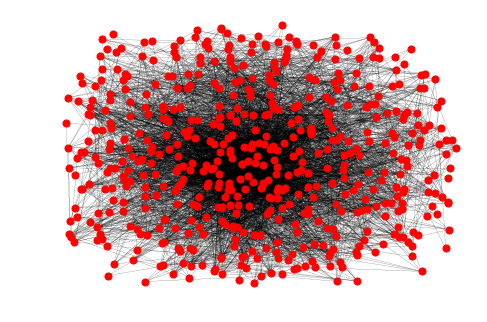

Algebraic Connectivity:
(76.32544659172999+0j)
====
Fiedler vector:
[-2.16772617e-04+0.j  1.41026805e-04+0.j -4.57341516e-04+0.j
  8.31208560e-05+0.j -1.65195376e-05+0.j -6.81479154e-04+0.j]


In [12]:
largest_cc = list(max(nx.connected_components(G), key=len))
cc_g = G.subgraph(largest_cc)
nx.draw(cc_g, node_size= 50, width=.15, pos=nx.spring_layout(cc_g, k=0.25, iterations=5))
plt.show()
lp = nx.linalg.laplacianmatrix.laplacian_matrix(cc_g)
lp = lp.asfptype()
l, v = sparse.linalg.eigs(lp) # Eigenvalues for laplacian matrix
print("Algebraic Connectivity:")
print(l[-2])
print("====")
print("Fiedler vector:")
print(v[-2])

Upper value: 461
Epsilon Value: 0.0390330166085


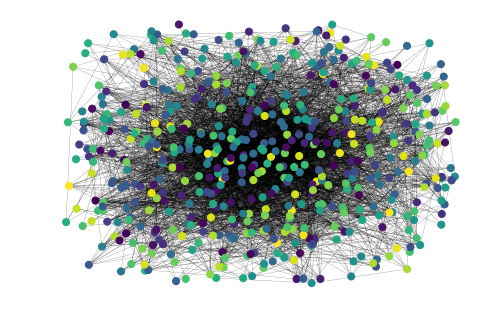

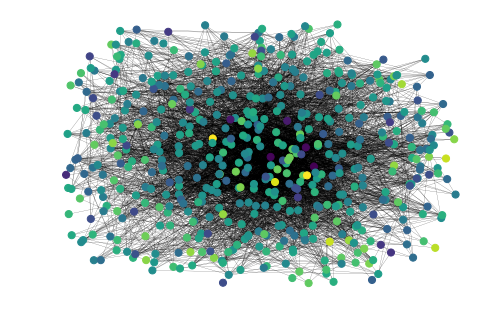

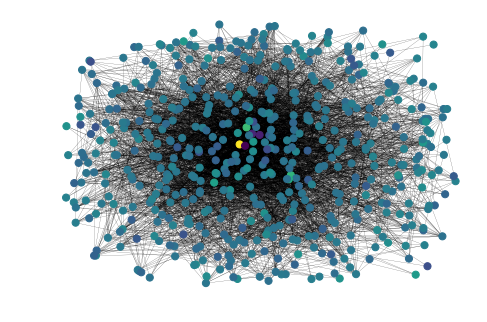

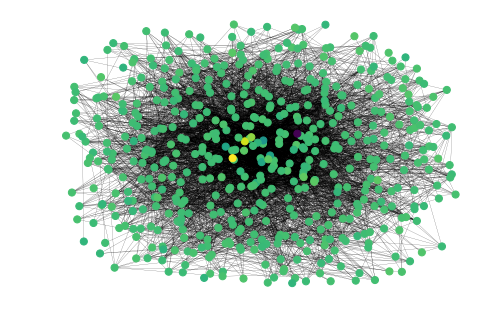

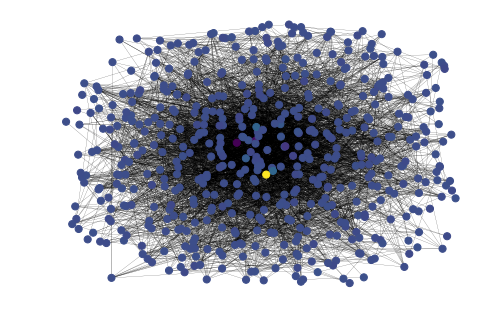

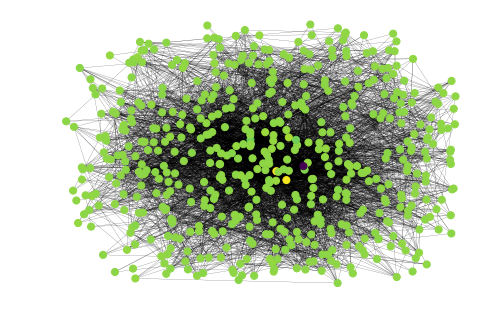

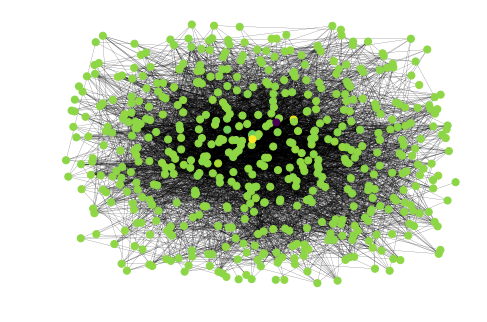

In [19]:
def concensus(graph, TIME_STEPS):
    rangeTop = random.randint(10, 500) # Decide the upper level of the range
    e = random.uniform(0.01, 0.1)  # Epsilon value
    print("Upper value: " + str(rangeTop))
    print("Epsilon Value: " + str(e))
    # Set the value for every node in the graph
    for x in graph.nodes():
        nx.set_node_attributes(graph, {x: {'valState': random.randint(0, rangeTop)}})
    
    nx.draw(graph, node_color=nx.get_node_attributes(graph, 'valState').values(), node_size= 50, width=.15, pos=nx.spring_layout(graph, k=0.25, iterations=5))
    plt.show()
    # For the number of time steps, go through every node and get the new value, then set it
    for y in range(TIME_STEPS):
        newVals = []
        for x in graph.nodes():
            s = 0
            for n in graph.neighbors(x):
                s += (nx.get_node_attributes(graph, 'valState')[n] - nx.get_node_attributes(graph, 'valState')[x])
            nv = nx.get_node_attributes(graph, 'valState')[x] + (e * s)
            newVals.append((x, nv))
        for x in newVals:
            nx.set_node_attributes(graph, {x[0]: {'valState': x[1]}})
        nx.draw(graph, node_color=nx.get_node_attributes(graph, 'valState').values(), node_size= 50, width=.15, pos=nx.spring_layout(graph, k=0.25, iterations=5))
        plt.show()
    nx.draw(graph, node_color=nx.get_node_attributes(graph, 'valState').values(), node_size= 50, width=.15, pos=nx.spring_layout(graph, k=0.25, iterations=5))
    plt.show()
        
concensus(G, 5)